# Cliff Walking Q Learning
## Example Description
![cliff_walking](../images/lecture_2/cliff_walking.png)

## Gymnasium
Cliff walking involves crossing a gridworld from start to goal while avoiding falling off a cliff.

### Description
The game starts with the player at location [3, 0] of the 4x12 grid world with the
goal located at [3, 11]. If the player reaches the goal the episode ends.

A cliff runs along [3, 1..10]. If the player moves to a cliff location it
returns to the start location.

The player makes moves until they reach the goal.

Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction
by Sutton and Barto [<a href="#cliffwalk_ref">1</a>].

With inspiration from:
[https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py)

### Action Space
The action shape is `(1,)` in the range `{0, 3}` indicating
which direction to move the player.

- 0: Move up
- 1: Move right
- 2: Move down
- 3: Move left

### Observation Space
There are 3 x 12 + 1 possible states. The player cannot be at the cliff, nor at
the goal as the latter results in the end of the episode. What remains are all
the positions of the first 3 rows plus the bottom-left cell.

The observation is a value representing the player's current position as
current_row * nrows + current_col (where both the row and col start at 0).

For example, the stating position can be calculated as follows: 3 * 12 + 0 = 36.

The observation is returned as an `int()`.

### Starting State
The episode starts with the player in state `[36]` (location [3, 0]).

### Reward
Each time step incurs -1 reward, unless the player stepped into the cliff,
which incurs -100 reward.

### Episode End
The episode terminates when the player enters state `[47]` (location [3, 11]).

### Information

`step()` and `reset()` return a dict with the following keys:
- "p" - transition proability for the state.

As cliff walking is not stochastic, the transition probability returned always 1.0.

### Arguments

```python
import gymnasium as gym
gym.make('CliffWalking-v0')
```

### References
<a id="cliffwalk_ref"></a>[1] R. Sutton and A. Barto, “Reinforcement Learning:
An Introduction” 2020. [Online]. Available: [http://www.incompleteideas.net/book/RLbook2020.pdf](http://www.incompleteideas.net/book/RLbook2020.pdf)

### Version History
- v0: Initial version release


## Q Learning Algorithm
![q_learning](../images/lecture_2/q_learning.png)

## Import Env

In [1]:
import gymnasium as gym
for k, v in gym.envs.registry.items():
    print(str(k)+"\t"+str(v))
from gymnasium.envs.toy_text.cliffwalking import CliffWalkingEnv


CartPole-v0	EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
CartPole-v1	EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
MountainCar-v0	EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.

In [2]:
env = gym.make("CliffWalking-v0")
print("Shape of observation: ", env.observation_space)
print("Number of action: ", env.action_space.n)


Shape of observation:  Discrete(48)
Number of action:  4


## Epsilon-greedy Decision

In [3]:
from typing import Dict
import numpy as np
from collections import defaultdict


def epsilon_greedy(q: Dict[int, np.ndarray], state: int, num_actions: int, epsilon):
    probability = np.ones(num_actions)*epsilon/num_actions
    idx_action_with_max_q = np.argmax(q[state])
    probability[idx_action_with_max_q] = 1-np.sum(probability[1:])
    return np.random.choice(np.arange(num_actions), p=probability)


epsilon_greedy(defaultdict(lambda: np.zeros(env.action_space.n)),
               0, env.action_space.n, 0.1)


0

## Solution with Sarsa
![sarsa](../images/lecture_2/sarsa.png)

In [4]:
from typing import Tuple, List


def sarsa(env: gym.Env, num_episodes, gamma=0.9, alpha=0.1, epsilon=0.1) -> Tuple[Dict[int, np.ndarray], List, List]:
    """
        gamma: the reward discount factor
        alpha: the updating ratio of q
        epsilon: the epsilon-greedy praramter
    """
    q = defaultdict(lambda: np.zeros(env.action_space.n))
    sarsa_num_attempt_per_episode = defaultdict(int)
    sarsa_reward_per_episode = defaultdict(float)
    for episode_i in range(num_episodes):
        state = env.reset()[0]
        action = epsilon_greedy(q, state, env.action_space.n, epsilon)
        is_terminated = False
        while not is_terminated:
            next_state, reward, is_terminated,is_truncated, info = env.step(action)
            next_action = epsilon_greedy(
                q, next_state, env.action_space.n, epsilon)
            q[state][action] += alpha * \
                (reward+gamma*q[next_state][next_action]-q[state][action])

            state = next_state
            action = next_action

            sarsa_num_attempt_per_episode[episode_i] += 1
            sarsa_reward_per_episode[episode_i] += reward
    
    return q,sarsa_num_attempt_per_episode,sarsa_reward_per_episode


In [5]:
q_sarsa,sarsa_num_attempt_per_episode,sarsa_reward_per_episode=sarsa(env,int(1e3))

In [6]:
import matplotlib.pyplot as plt
def plot_attempt_per_episode(num_attempt_per_episode:Dict[int,int]):
    fig,ax=plt.subplots()
    ax.plot([k for k in num_attempt_per_episode.keys()],[v for v in num_attempt_per_episode.values()])
def plot_reward_per_episode(reward_per_episode):
    fig,ax=plt.subplots()
    ax.plot([k for k in reward_per_episode.keys()],[v for v in reward_per_episode.values()])
def plot_learning_trend(num_attempt_per_episode):
    fig,ax=plt.subplots()
    ax.plot(np.cumsum([v for v in num_attempt_per_episode.values()]),np.arange(len(num_attempt_per_episode)))

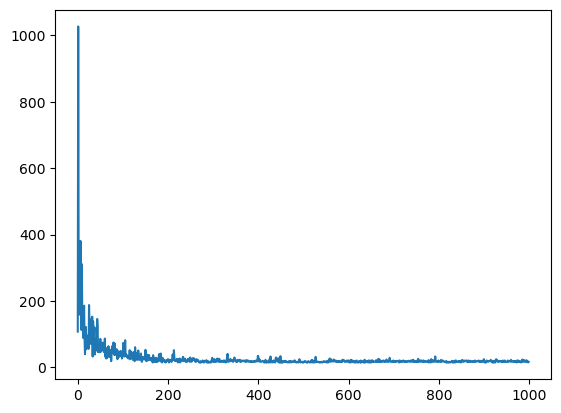

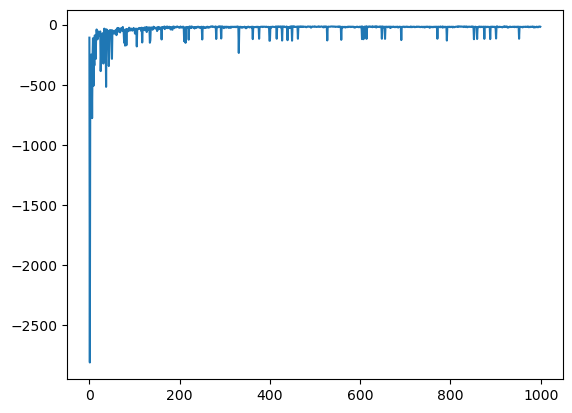

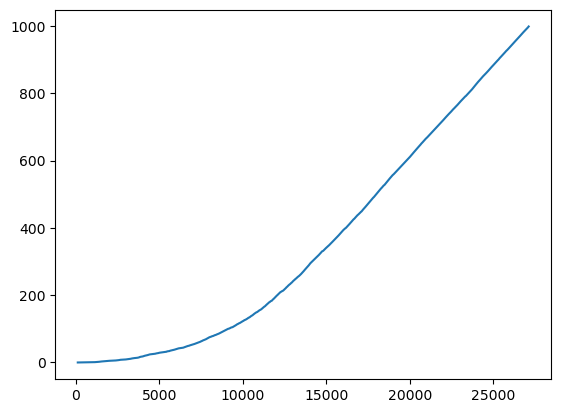

In [7]:
plot_attempt_per_episode(sarsa_num_attempt_per_episode)
plot_reward_per_episode(sarsa_reward_per_episode)
plot_learning_trend(sarsa_num_attempt_per_episode)

## Solution with Q-learning
![q_learning](../images/lecture_2/q_learning.png)

In [8]:
def q_learning(env:gym.Env,num_episodes:int,gamma:float=0.9,alpha:float=0.1,epsilon:float=0.1):
    q=defaultdict(lambda:np.zeros(env.action_space.n))
    q_learning_num_attempt_per_episode=defaultdict(int)
    q_learning_reward_per_episode=defaultdict(float)
    for episode_i in range(num_episodes):
        state=env.reset()[0]
        is_terminated=False
        while not is_terminated:
            action=epsilon_greedy(q,state,env.action_space.n,epsilon)
            next_state,reward,is_terminated,is_truncated,info=env.step(action)
            # Different from SARSA
            q[state][action]+=alpha*(reward+gamma*q[next_state][np.argmax(q[next_state])]-q[state][action])
            
            state=next_state
            
            q_learning_num_attempt_per_episode[episode_i]+=1
            q_learning_reward_per_episode[episode_i]+=reward
    return q,q_learning_num_attempt_per_episode,q_learning_reward_per_episode

In [9]:
q_q_learning,q_learning_num_attempt_per_episode,q_learning_reward_per_episode=q_learning(env,int(1e3))

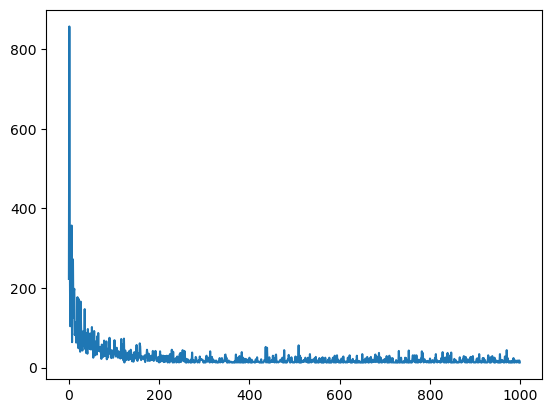

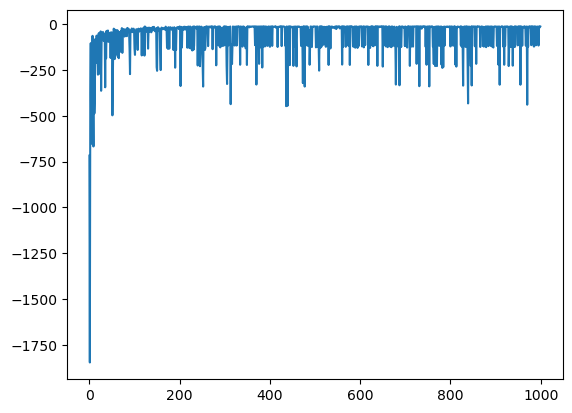

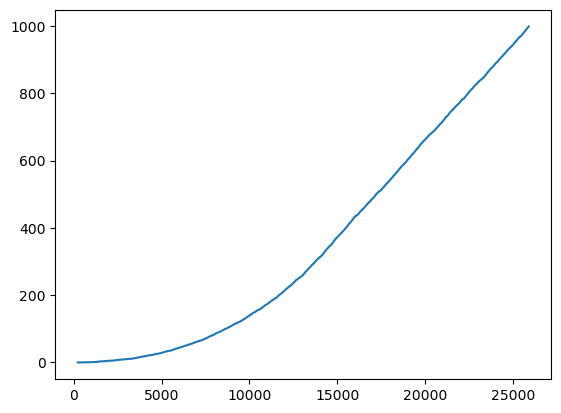

In [10]:
plot_attempt_per_episode(q_learning_num_attempt_per_episode)
plot_reward_per_episode(q_learning_reward_per_episode)
plot_learning_trend(q_learning_num_attempt_per_episode)

## Compare SARSA with Q-learning

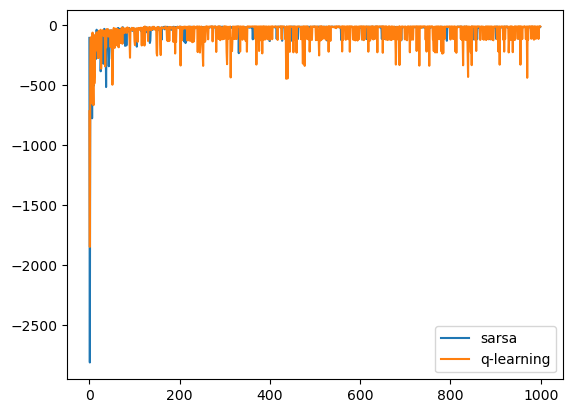

In [11]:
def plot_comparison(sarsa_reward_per_episode:Dict[int,float],q_learning_reward_per_episode:Dict[int,float]):
    fig,ax=plt.subplots()
    ax.plot([k for k in sarsa_reward_per_episode.keys()],[v for v in sarsa_reward_per_episode.values()],label="sarsa")
    ax.plot([k for k in q_learning_reward_per_episode.keys()],[v for v in q_learning_reward_per_episode.values()],label="q-learning")
    ax.legend()

plot_comparison(sarsa_reward_per_episode,q_learning_reward_per_episode)
    